# Descripción
Con el fin de generar un modelo predictivo para el valor de las acciones de la compañía Tesla Motors, se analizará la relación entre las noticias publicadas en la página 'El País' sobre la compañía y el precio de la misma. Se aplicará técnicas de procesamiento de lenguaje natural y se mostrará la correlación para obtener un modelo de clasificación.

Enlace: https://cincodias.elpais.com/tag/tesla_motors/

# Obtención de datos
El archivo <b>scrap.py</b> se encarga de obtener los datos de noticias y guardarlos en un archivo separado por comas. 

Los datos historicos sobre la compañía se obtienen de https://finance.yahoo.com/quote/TSLA/history?period1=1628207417&period2=1659743417&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true .

De antemano se sabe que no hay datos faltantes en el conjunto.

# Exploración

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.impute import SimpleImputer
import numpy as np
import spacy
import re
import string
import seaborn as sns

df_news = pd.read_csv('Data/news_data.csv')
df_stocks = pd.read_csv('Data/TSLA.csv')

print(
    f'Estructura noticias: {df_news.shape}. Estructura stocks: {df_stocks.shape}')
df_news.head()


Estructura noticias: (937, 4). Estructura stocks: (2322, 7)


,Titulo,Texto,Fecha,Tipo
0,Elon Musk cree que la inflación ha llegado a s...,"El consejero delegado de Tesla, Elon Musk, cre...",/tag/fecha/20220805,Junta General
1,Sorpresa: el Tesla Roadster podría ser present...,En 2023 tenemos varias citas importantes con T...,/tag/fecha/20220804,Motor
2,Twitter involucra a los amigos de Elon Musk en...,Twitter presiona en su querella contra Elon Mu...,/tag/fecha/20220802,Tecnología>
3,Los CEO de Atlassian dan una lección valiosa a...,¿Hasta qué punto deben los jefes multimillonar...,/tag/fecha/20220802,Breakingviews
4,El Tesla Model 3 ya no es el coche eléctrico m...,"En los últimos años, Tesla ha arrasado en vent...",/tag/fecha/20220801,Motor


In [2]:
def formato_fecha(fecha):
    # Convierte a formato aaaa-mm-dd
    fecha_ = fecha.replace(' ', '').split('/')
    fecha = fecha_[-1]
    year = fecha[:4]
    mes = fecha[4:6]
    dia = fecha[6:]
    return f'{year}-{mes}-{dia}'


df_news['Fecha'] = df_news['Fecha'].apply(formato_fecha)
f"Intervalo de entradas: {df_news['Fecha'].iloc[-1]}, {df_news['Fecha'].iloc[0]}"


'Intervalo de entradas: 2013-05-16, 2022-08-05'

## Pre-procesamiento
Se realiza para obtener más valor del texto y estandarizar.

In [3]:

nlp = spacy.load("es_core_news_sm")
stopwords = spacy.lang.es.stop_words.STOP_WORDS


def normalize(comment, lowercase, remove_stopwords):
    try:
        comment = comment.lower()
    except:
        print(comment)
        return ''
    comment = re.sub('\[.*?\]', '', comment)
    comment = re.sub("\\W", " ", comment)
    comment = re.sub('https?://\S+|www\.\S+', '', comment)
    comment = re.sub('<.*?>+', '', comment)
    comment = re.sub('[%s]' % re.escape(string.punctuation), '', comment)
    comment = re.sub('\n', '', comment)
    comment = re.sub('\w*\d\w*', '', comment)
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stopwords):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


df_news['Titulo'] = df_news['Titulo'].apply(
    normalize, lowercase=True, remove_stopwords=True)
df_news['Tipo'] = df_news['Tipo'].apply(
    normalize, lowercase=True, remove_stopwords=True)
df_news['Texto'] = df_news['Texto'].apply(
    normalize, lowercase=True, remove_stopwords=True)


nan
nan
nan


## Distribución del tipo de notas

In [34]:
text = ''
for data in df_news['Tipo']:
    text += f'{data} '

aux = pd.DataFrame({
    'Palabras': text.split(' ')
})


aux['Cantidad'] = aux['Palabras'].apply(lambda x: aux[aux['Palabras'] == x].shape[0])
aux.drop_duplicates(inplace=True)
aux.sort_values(by='Cantidad', ascending=False, inplace=True)
later = aux.copy()

(-0.5, 999.5, 599.5, -0.5)

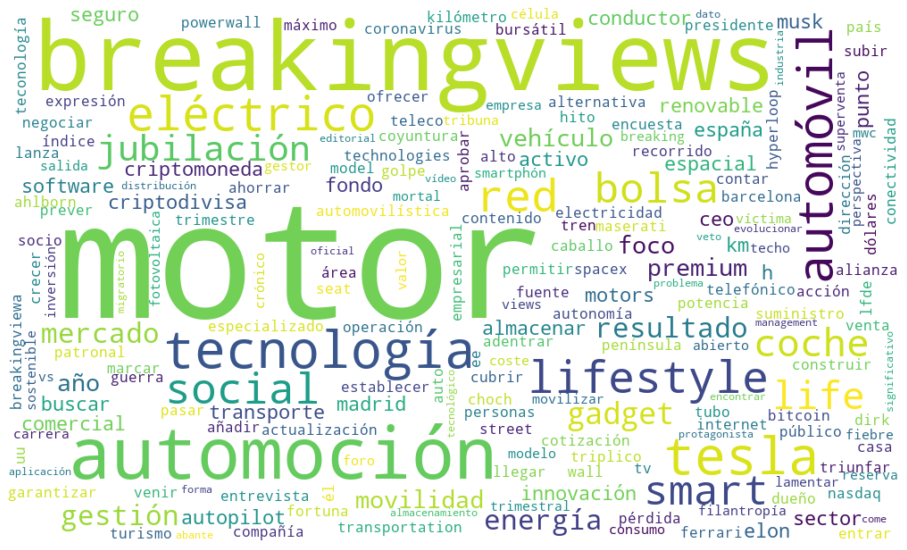

In [35]:
plt.rcParams["figure.figsize"] = (16, 10)
word_cloud = WordCloud(background_color="white",
                       max_words=350,
                       width=1000,
                       height=600,
                       random_state=1).generate_from_frequencies(aux.set_index('Palabras').to_dict()['Cantidad'])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

## Visualización de los stocks de Tesla

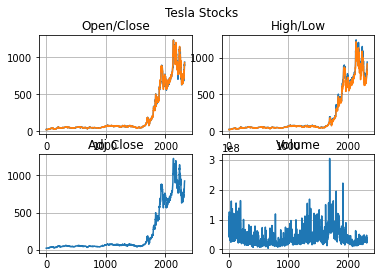

In [6]:
fig, ax = plt.subplots(2, 2)
fig.suptitle('Tesla Stocks')

ax[0, 0].plot(df_stocks.index, df_stocks['Open'])
ax[0, 0].plot(df_stocks.index, df_stocks['Close'])
ax[0, 0].set_title('Open/Close')
ax[0, 0].grid()

ax[0, 1].plot(df_stocks.index, df_stocks['High'])
ax[0, 1].plot(df_stocks.index, df_stocks['Low'])
ax[0, 1].set_title('High/Low')
ax[0, 1].grid()

ax[1, 0].plot(df_stocks.index, df_stocks['Adj Close'])
ax[1, 0].set_title('Adj Close')
ax[1, 0].grid()

ax[1, 1].plot(df_stocks.index, df_stocks['Volume'])
ax[1, 1].set_title('Volume')
ax[1, 1].grid()


In [7]:
def set_target(open, close):
    if close - open > 0:
        return 1
    else:
        return 0


def set_volume(volume, mean):
    if volume > mean:
        return 1
    else:
        return 0


mean_volume = df_stocks.mean()['Volume']
df_stocks['Change'] = df_stocks.apply(
    lambda x: set_target(x['Open'], x['Close']), axis=1)
df_stocks['Volume'] = df_stocks.apply(
    lambda x: set_volume(x['Volume'], mean_volume), axis=1)
df_stocks = df_stocks.drop(['Open', 'Close', 'Adj Close'], axis=1)


<ipython-input-7-d4a60841b04b>:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_volume = df_stocks.mean()['Volume']


## Se juntarán las notas con la misma fecha

In [8]:
def most_frequent(List):
    return max(set(List), key = List.count)

aux = df_news.groupby('Fecha')
notas, tipo, fechas = [], [], []
for fecha in df_news['Fecha'].unique():
    nota = ''
    aux_tipo = []
    for text, tipe in zip(aux.get_group(fecha)['Texto'], aux.get_group(fecha)['Tipo']):
        nota += str(text)
        aux_tipo.append(tipe)

    tipo.append(most_frequent(aux_tipo))
    notas.append(nota)
    fechas.append(fecha)
df_news = pd.DataFrame({'Texto': notas, 'Fecha': fechas, 'Tipo': tipo})

In [9]:
df_news['Cambio'] = df_news['Fecha'].map(df_stocks.set_index('Date')['Change'])
df_news['Volumen'] = df_news['Fecha'].map(
    df_stocks.set_index('Date')['Volume'])
    
df_news['Maximo'] = df_news['Fecha'].map(df_stocks.set_index('Date')['High'])
df_news['Minimo'] = df_news['Fecha'].map(df_stocks.set_index('Date')['Low'])
df_news = df_news.drop(['Fecha'], axis=1)
print(df_news.shape)
df_news.head()


(751, 6)


,Texto,Tipo,Cambio,Volumen,Maximo,Minimo
0,consejero delegado tesla elon musk creer infla...,junta general,NaN,NaN,NaN,NaN
1,cita importante tesla año elegido fabricante l...,motor,0.0,0.0,940.820007,915.000000
2,twitter presionar querella elon musk buscar ex...,tecnología,1.0,0.0,923.500000,878.000000
3,año tesla arrasar venta gigante motor eléctric...,motor,0.0,1.0,935.630005,885.000000
4,coche eléctrico esperado tesla cybertruck vehí...,motor,1.0,0.0,827.780029,785.369995


In [10]:
print(df_news.isnull().sum())
df_news = df_news.dropna(axis=0)

Texto       0
Tipo        0
Cambio     58
Volumen    58
Maximo     58
Minimo     58
dtype: int64


In [39]:
text = ''
for data in df_news[df_news['Cambio']==1]['Tipo']:
    text += f'{data} '

aux = pd.DataFrame({
    'Palabras': text.split(' ')
})


aux['Cantidad'] = aux['Palabras'].apply(lambda x: aux[aux['Palabras'] == x].shape[0])
aux.drop_duplicates(inplace=True)
aux.sort_values(by='Cantidad', ascending=False, inplace=True)
aux = aux[2:]

In [40]:
word_cloud_1 = WordCloud(background_color="white", 
               max_words=350, 
               width=1000, 
               height=600, 
               random_state=1).generate_from_frequencies(aux.set_index('Palabras').to_dict()['Cantidad'])

In [41]:
text = ''
for data in df_news[df_news['Cambio']==0]['Tipo']:
    text += f'{data} '

aux = pd.DataFrame({
    'Palabras': text.split(' ')
})


aux['Cantidad'] = aux['Palabras'].apply(lambda x: aux[aux['Palabras'] == x].shape[0])
aux.drop_duplicates(inplace=True)
aux.sort_values(by='Cantidad', ascending=False, inplace=True)
aux = aux[2:]

In [42]:
word_cloud_0 = WordCloud(background_color="white", 
               max_words=350, 
               width=1000, 
               height=600, 
               random_state=1).generate_from_frequencies(aux.set_index('Palabras').to_dict()['Cantidad'])

No se tomara en cuenta las palabras mas comunes en el texto

(-0.5, 999.5, 599.5, -0.5)

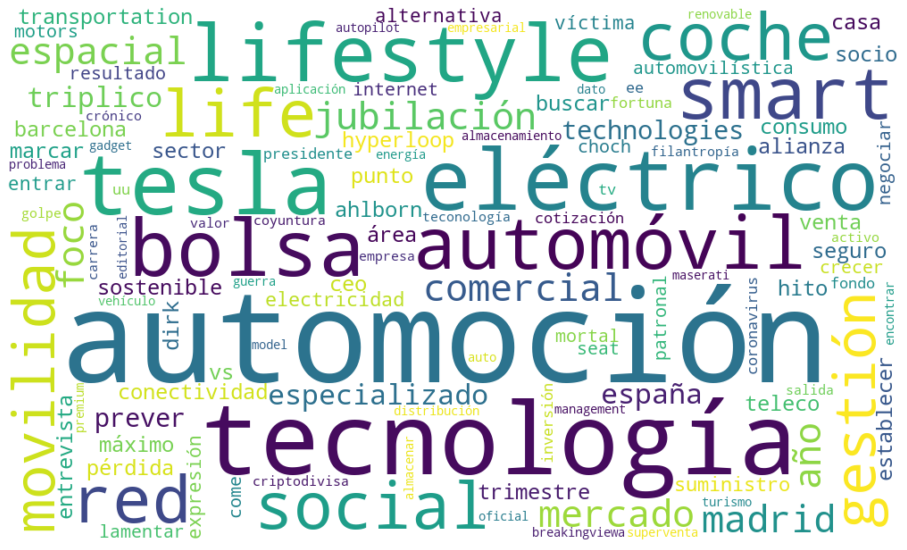

In [43]:
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis('off')

(-0.5, 999.5, 599.5, -0.5)

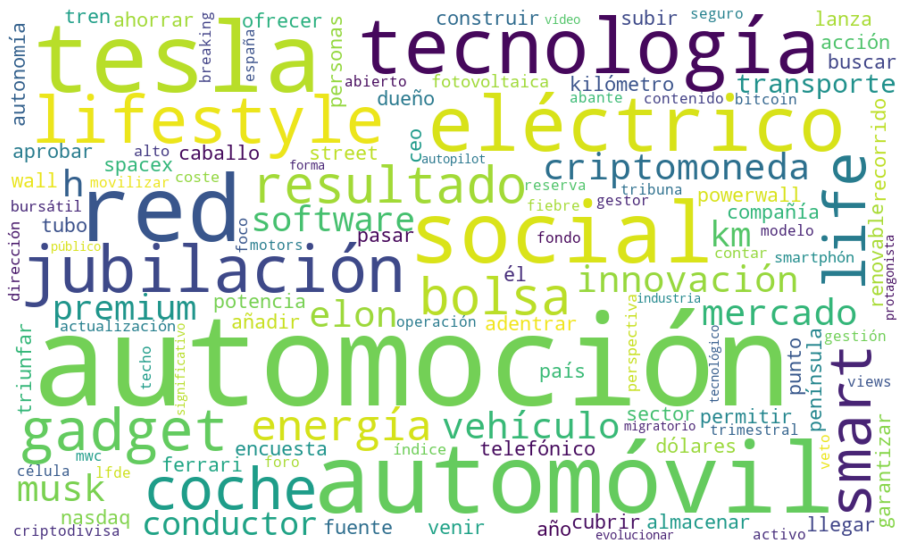

In [44]:
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.axis('off')

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
V = TfidfVectorizer()
RFR = RandomForestRegressor(max_depth=10, random_state=0)
XGBR = XGBRegressor(n_estimators=800, learning_rate = 0.05)


In [18]:
def quita(x):
    for word in later['Palabras'][:8]:
        x = x.replace(word, '')
    return x

df_news['Texto'] = df_news['Texto'].apply(quita)

In [19]:
df_news.head()

,Texto,Tipo,Cambio,Volumen,Maximo,Minimo
1,cita importante año elegido fabricante lanzar...,motor,0.0,0.0,940.820007,915.000000
2,twitter presionar querella elon musk buscar ex...,tecnología,1.0,0.0,923.500000,878.000000
3,año arrasar venta gigante dominar completo ...,motor,0.0,1.0,935.630005,885.000000
4,esperado cybertruck vehículo dejar sufrir r...,motor,1.0,0.0,827.780029,785.369995
5,últimamente subida precio principal modelo añ...,tesla motors,0.0,0.0,822.440002,802.200012


## Prueba uno

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    df_news['Texto'], df_news['Maximo'], random_state=0)
XV_train = V.fit_transform(raw_documents=X_train)
XV_test = V.transform(X_test)
RFR.fit(XV_train, y_train)


RandomForestRegressor(max_depth=10, random_state=0)

In [21]:
predict_1 = RFR.predict(XV_test)
score = RFR.score(XV_test, y_test)
print(f'Puntuación: {score}')


Puntuación: 0.16679413200209114


In [22]:
XGBR.fit(XV_train, y_train)
predict_2 = XGBR.predict(XV_test)
score = XGBR.score(XV_test, y_test)
print(f'Puntuación: {score}')


Puntuación: 0.16901206889694065


In [23]:
df_predict = pd.DataFrame({
    'Matrix': X_test,
    'Real': y_test,
    'Predict uno': predict_1,
    'Predict dos': predict_2
})
df_predict.head()


,Matrix,Real,Predict uno,Predict dos
498,firma elon musk camino roadster presentado me...,66.057999,121.453812,64.907372
162,tiempo mala venta temer pérdida lunes present...,724.000000,278.565153,221.245819
652,consejero delegado elon musk anunciar julio c...,74.269997,128.791741,102.867287
630,recarga característica frente vehículo gaso...,71.494003,106.396927,47.420883
396,invento pasar año cumplir inamovible parecer c...,49.689999,145.917415,107.457504


## Prueba 2

In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

XGBC = XGBClassifier(n_estimators=800, learning_rate = 0.05)
RFC = RandomForestClassifier(max_depth=10, random_state=0)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df_news['Texto'], df_news['Cambio'], random_state=0)
XV_train = V.fit_transform(raw_documents=X_train)
XV_test = V.transform(X_test)
RFC.fit(XV_train, y_train)


RandomForestClassifier(max_depth=10, random_state=0)

In [26]:
predict = RFC.predict(XV_test)
score = RFC.score(XV_test, y_test)
print(f'Puntuación: {score}')


Puntuación: 0.5114942528735632


In [27]:
df_predict = pd.DataFrame({
    'Matrix': X_test,
    'Real': y_test,
    'Predict': predict
})
df_predict.head()

,Matrix,Real,Predict
498,firma elon musk camino roadster presentado me...,0.0,0.0
162,tiempo mala venta temer pérdida lunes present...,0.0,0.0
652,consejero delegado elon musk anunciar julio c...,0.0,1.0
630,recarga característica frente vehículo gaso...,0.0,0.0
396,invento pasar año cumplir inamovible parecer c...,0.0,1.0


# Pruebas cross validation


In [28]:
df_aux = df_news[df_news['Tipo']=='motor']
print(df_aux.shape)
df_aux.head()

(400, 6)


,Texto,Tipo,Cambio,Volumen,Maximo,Minimo
1,cita importante año elegido fabricante lanzar...,motor,0.0,0.0,940.820007,915.000000
3,año arrasar venta gigante dominar completo ...,motor,0.0,1.0,935.630005,885.000000
4,esperado cybertruck vehículo dejar sufrir r...,motor,1.0,0.0,827.780029,785.369995
8,mejora preparar mejora entretenimiento permi...,motor,0.0,0.0,751.549988,718.809998
17,elon musk visionario gustar método dueño funda...,motor,0.0,0.0,718.500000,683.739990


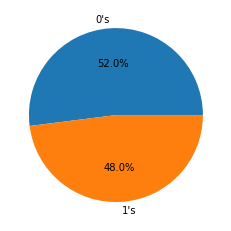

In [29]:
a = df_aux[df_aux['Cambio'] == 0].value_counts('Cambio')[0]
b = df_aux.shape[0] - a

plt.pie([a,b], labels=["0's","1's"], autopct='%1.1f%%')
plt.show()

## Prueba uno

In [30]:
clf = Pipeline(steps=[
    ('vect', TfidfVectorizer()),
    ('model', RandomForestClassifier(
        n_estimators=50,
        max_depth=10, 
        random_state=0
        ))
])
scores = cross_val_score(clf, df_news['Texto'], df_news['Cambio'],
                              cv=5,scoring='accuracy')
print("Scores:\n", scores)

Scores:
 [0.50359712 0.53956835 0.51798561 0.52898551 0.52898551]


In [31]:
clf = Pipeline(steps=[
    ('vect', TfidfVectorizer()),
    ('model', XGBClassifier(n_estimators=800, learning_rate = 0.05))
])
scores = cross_val_score(clf, df_news['Texto'], df_news['Cambio'],
                              cv=5,scoring='accuracy')
print("Scores:\n", scores)

Scores:
 [0.52517986 0.5323741  0.48201439 0.49275362 0.49275362]


## Prueba dos

In [32]:
clf = Pipeline(steps=[
    ('vect', TfidfVectorizer()),
    ('model', RandomForestClassifier(
        n_estimators=50,
        max_depth=10, 
        random_state=0
        ))
])
scores = cross_val_score(clf, df_aux['Texto'], df_aux['Cambio'],
                              cv=5,scoring='accuracy')
print("Scores:\n", scores)

Scores:
 [0.475  0.5    0.3875 0.4625 0.4625]


In [33]:
clf = Pipeline(steps=[
    ('vect', TfidfVectorizer()),
    ('model', XGBClassifier(n_estimators=800, learning_rate = 0.05))
])
scores = cross_val_score(clf, df_aux['Texto'], df_aux['Cambio'],
                              cv=5,scoring='accuracy')
print("Scores:\n", scores)

Scores:
 [0.4125 0.525  0.4    0.4125 0.475 ]


# Conclusión
Por desgracia no existe una relación significativa entre el texto y el cambio presente en el valor de las acciones.

Es probable obtener un mejor resultado si para cada fecha existe al menos una noticia, es decir, un conjunto de datos más homogéneo. Hay que tener en cuenta que este proyecto no es dirigido a generar un modelo que prediga el cambio en las acciones, pues está orientado a observar una posible relación entre las noticias y el cambio; ya que el orden de la obtención de los datos en un entorno real es diferente al realizado aquí.